In [1]:
import pandas as pd
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from typing import List, Optional
import io

# preproc

In [2]:
df_txs = pl.read_csv('./data/LI-Small_Trans.csv', try_parse_dates = True)
#df_com = pl.read_csv('./data/LI-Small_accounts.csv')

In [3]:
rename_map = {
  'Timestamp': 'timestamp',
  'From Bank': 'from_bank',
  'To Bank': 'to_bank',
  'Amount Received': 'amount_received',
  'Receiving Currency': 'receiving_currency',
  'Amount Paid': 'amount_sent',
  'Payment Currency': 'payment_currency',
  'Payment Format': 'payment_format',
  'Is Laundering': 'is_laundering',
  'Account': 'from_account',
  'Account_duplicated_0': 'to_account'
}

In [4]:
def process_data(
    df: pl.DataFrame,
    rename_map: dict[str, str],
    is_pattern: bool = False,
    cmap: Optional[dict[str, int]] = None,
    fmap: Optional[dict[str, int]] = None
    ) -> tuple[
      pl.DataFrame,
      Optional[dict[str, int]],
      Optional[dict[str, int]],
    ]:
  df = df.rename(rename_map)

  if not is_pattern:
    unq_currs = (
      pl.concat([df['receiving_currency'], df['payment_currency']], how = 'vertical')
      .unique()
      .to_list()
    )
    cmap = {v: i for i, v in enumerate(unq_currs)}
    #reversed_cmap = {i: v for v, i in cmap.items()}

    unq_fmts = df['payment_format'].unique().to_list()
    fmap = {v: i for i, v in enumerate(unq_fmts)}
    #reversed_fmap = {i: v for v, i in fmap.items()}
  else:
    if cmap is None or fmap is None:
      raise ValueError("cmap and fmap must be provided when is_pattern is True")
    
    all_currs = (
      pl.concat([
        df['receiving_currency'],
        df['payment_currency']
      ], how = 'vertical')
      .unique()
      .to_list()
    )
    for curr in all_currs:
      if curr not in cmap:
        raise ValueError(f"Currency {curr} not found in cmap")

  df = df.with_columns([
    pl.col('is_laundering').cast(pl.UInt8),
    pl.col('receiving_currency').replace(cmap).cast(pl.UInt8),
    pl.col('payment_currency').replace(cmap).cast(pl.UInt8),
    pl.col('payment_format').replace(fmap).cast(pl.UInt8),
    pl.col('from_bank').cast(pl.UInt32),
    pl.col('to_bank').cast(pl.UInt32),
    pl.col('timestamp').dt.strftime('%Y-%m-%d %H:%M:%S').cast(pl.String).alias('timestamp')
  ])

  if is_pattern:
    return df

  return df, cmap, fmap

In [5]:
df_txs, cmap, fmap = process_data(
    df_txs,
    rename_map,
    is_pattern = False
)

In [6]:
# df_com = df_com.rename({
#   'Bank Name': 'bank_name',
#   'Bank ID': 'bank_id',
#   'Account Number': 'account_id',
#   'Entity ID': 'com_id',
#   'Entity Name': 'com_name'
# })

# graph generation

In [7]:
def extract_graph_data(
    df_txs: pl.DataFrame,
    save_path: str | None = None
) -> tuple[pl.DataFrame, pl.DataFrame]:
  nodes = (
    pl.concat([
      df_txs.select([
        pl.col('from_account').alias('account')
      ]),
      df_txs.select([
        pl.col('to_account').alias('account')
      ])
    ])
    .unique()
    .with_row_index('node_id')
  )
  
  node_lookup = nodes.select(['account', 'node_id'])

  edges = (
    df_txs
    .join(
      node_lookup.rename({'account': 'from_account', 'node_id': 'src'}),
      on='from_account',
      how='left'
    )
    .join(
      node_lookup.rename({'account': 'to_account', 'node_id': 'dst'}),
      on='to_account',
      how='left'
    )
    .select([
      'src',
      'dst',
      'timestamp',
      'from_bank',
      'to_bank',
      'amount_sent',
      'amount_received',
      'payment_currency',
      'receiving_currency',
      'payment_format',
      'is_laundering'
    ])
  )

  if save_path is not None:
    nodes.write_csv(f'{save_path}/nodes.csv')
    edges.write_csv(f'{save_path}/edges.csv')

  return nodes, edges

In [8]:
nodes, edges = extract_graph_data(df_txs)

In [9]:
del df_txs

In [10]:
def construct_graph(
    nodes: pl.DataFrame,
    edges: pl.DataFrame
) -> tuple[nx.MultiDiGraph, List[tuple[int, int, int]]]:
  G = nx.MultiDiGraph()

  for row in nodes.iter_rows(named = True):
    G.add_node(
      row['node_id'],
      account = row['account']
    )
  
  for row in edges.iter_rows(named = True):
    G.add_edge(
      row['src'],
      row['dst'],
      timestamp = row['timestamp'],
      from_bank = row['from_bank'],
      to_bank = row['to_bank'],
      amount_sent = row['amount_sent'],
      amount_received = row['amount_received'],
      payment_currency = row['payment_currency'],
      receiving_currency = row['receiving_currency'],
      payment_format = row['payment_format'],
      is_laundering = row['is_laundering']
    )
  
  laundering_edges =[
    (u, v, k)
    for u, v, k, d in G.edges(data = True, keys = True)
    if d['is_laundering'] == 1 | d['is_laundering'] == True
  ]

  return G, laundering_edges

In [11]:
G, laundering_edges = construct_graph(nodes, edges)

# Patterns

In [12]:
PATTERN_COLS = [
  'Timestamp',
  'From Bank',
  'Account',
  'To Bank',
  'Account_duplicated_0',
  'Amount Received',
  'Receiving Currency',
  'Amount Paid',
  'Payment Currency',
  'Payment Format',
  'Is Laundering'
]

In [13]:
def read_patterns(path: str = './data/LI-Small_Patterns.txt') -> List[dict]:
  with open(path, 'r') as f:
    lines = [ln.strip() for ln in f.readlines() if ln.strip()]
  
  blocks = []
  curr_lines = []
  curr_name = None

  for ln in lines:
    if ln.startswith('BEGIN LAUNDERING ATTEMPT'):
      curr_name = ln.replace('BEGIN LAUNDERING ATTEMPT -', '').strip()
      curr_lines = []
    elif ln.startswith('END LAUNDERING ATTEMPT'):
      csv_buf = io.StringIO('\n'.join(curr_lines))
      df_raw = pl.read_csv(
        csv_buf,
        has_header = False,
        new_columns = PATTERN_COLS,
        try_parse_dates = True
      )
      blocks.append({
        'name': curr_name,
        'data': df_raw
      })
      curr_lines = []
      curr_name = None
    else:
      curr_lines.append(ln)

  return blocks

In [14]:
def attach_nodes(patterns_df: pl.DataFrame, nodes: pl.DataFrame) -> pl.DataFrame:
  pat = (
    patterns_df.join(
      nodes.rename({
        'account': 'from_account',
        'node_id': 'src'
      }),
      on = 'from_account',
      how = 'left'
    ).join(
      nodes.rename({
        'account': 'to_account',
        'node_id': 'dst'
      }),
      on = 'to_account',
      how = 'left'
    )
  )

  return pat

In [44]:
blocks = read_patterns()
t = process_data(blocks[4]['data'], rename_map, is_pattern = True, cmap = cmap, fmap = fmap)
d = attach_nodes(t, nodes)
d
# node_ids = (d['src'] + d['dst']).unique().to_list()
# node_ids

timestamp,from_bank,from_account,to_bank,to_account,amount_received,receiving_currency,amount_sent,payment_currency,payment_format,is_laundering,src,dst
str,u32,str,u32,str,f64,u8,f64,u8,u8,u8,u32,u32
"""2022-09-01 06:59:00""",26,"""801A29190""",1394,"""800853620""",4226.58,3,4226.58,3,4,1,491390,138704
"""2022-09-03 12:52:00""",1394,"""800853620""",20,"""800914620""",3970.01,3,3970.01,3,4,1,138704,389120
"""2022-09-02 04:12:00""",26,"""801A29190""",394,"""800606C90""",19382.19,3,19382.19,3,4,1,491390,336740
"""2022-09-03 14:24:00""",394,"""800606C90""",20,"""800914620""",19382.19,3,19382.19,3,4,1,336740,389120
"""2022-09-02 04:30:00""",26,"""801A29190""",531,"""800C31170""",12052.39,3,12052.39,3,4,1,491390,77804
…,…,…,…,…,…,…,…,…,…,…,…,…
"""2022-09-04 12:41:00""",1217,"""8001C5BC0""",20,"""800914620""",10530.92,3,10530.92,3,4,1,372723,389120
"""2022-09-03 11:46:00""",26,"""801A29190""",13125,"""801B416A0""",9741.1,3,9741.1,3,4,1,491390,27527
"""2022-09-04 15:45:00""",13125,"""801B416A0""",20,"""800914620""",11897.97,3,11897.97,3,4,1,27527,389120


In [45]:
for row in d.select(['src', 'dst']).iter_rows(named = True):
    print(f'{row["src"]} {row["dst"]}')

491390 138704
138704 389120
491390 336740
336740 389120
491390 77804
77804 389120
491390 372723
372723 389120
491390 27527
27527 389120
491390 465372
465372 389120


In [56]:
def draw_sub(H: nx.MultiDiGraph, title: str | None = None):
  if H.number_of_nodes() == 0:
    print("SubGraph has no nodes to draw.")
    return
  
  pos = nx.planar_layout(H)

  plt.figure(figsize = (8, 6))

  node_labels = {
    n: (attrs.get('node_id', str(n))) for n, attrs in H.nodes(data = True)
  }

  laundering_edges = []
  normal_edges = []
  for u, v, k, d in H.edges(keys = True, data = True):
    if d.get('is_laundering', 0) == 1 or d.get('is_laundering', False):
      laundering_edges.append((u, v, k))
    else:
      normal_edges.append((u, v, k))

  nx.draw_networkx_nodes(H, pos, node_size = 500)

  if normal_edges and not laundering_edges:
    nx.draw_networkx_edges(
      H,
      pos,
      edgelist = [(u, v) for (u, v, k) in normal_edges],
      arrows = True,
      width = 1.0
    )

  if laundering_edges:
    nx.draw_networkx_edges(
      H,
      pos,
      edgelist = [(u, v) for (u, v, k) in laundering_edges],
      arrows = True,
      edge_color = 'r',
      width = 2.5
    )

  nx.draw_networkx_labels(H, pos, labels = node_labels, font_size = 10)
  if title:
    plt.title(title)

  plt.axis('off')
  plt.tight_layout()
  plt.show()

In [57]:
def visualize_all_pats(
    path: str,
    node_lookup: pl.DataFrame,
    cmap: dict[str, int],
    fmap: dict[str, int],
    G: nx.MultiDiGraph
    ):
  blocks = read_patterns(path)
  for block in blocks:
    name = block['name']
    df_raw = block['data']
    df_proc = process_data(
        df_raw, rename_map,
        is_pattern = True, cmap = cmap, fmap = fmap
      )
    pat_ids = attach_nodes(df_proc, node_lookup)
    node_ids = pl.concat([pat_ids['src'], pat_ids['dst']], how='vertical').unique().to_list()
  

    print(f'Pattern: {name}')
    print(f'  #pattern rows: {df_proc.height}')
    print(f'  #nodes found: {len(node_ids)}')

    if not node_ids:
      print("  No nodes found for this pattern in the main graph.")
      continue

    H_sub = G.subgraph(node_ids).copy()

    draw_sub(H_sub, title = name)

Pattern: FAN-IN:  Max 3-degree Fan-In
  #pattern rows: 3
  #nodes found: 4


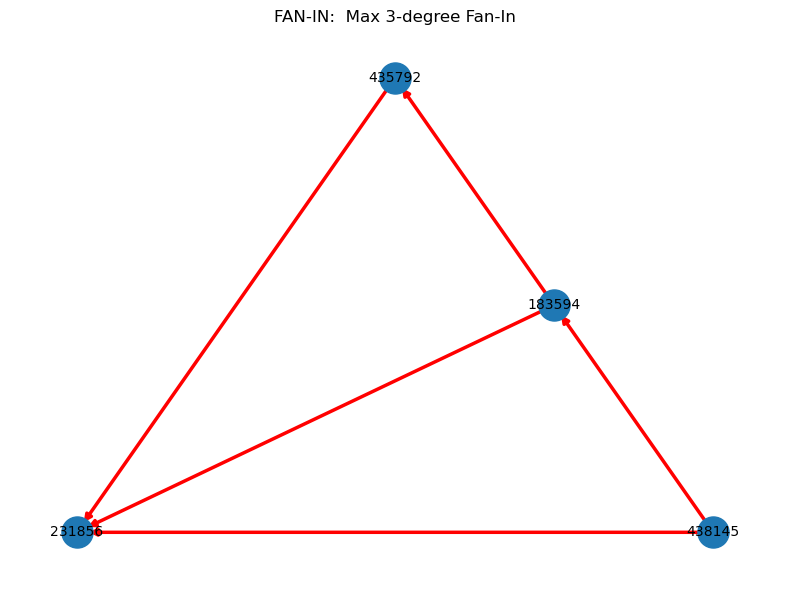

Pattern: FAN-IN:  Max 8-degree Fan-In
  #pattern rows: 8
  #nodes found: 9


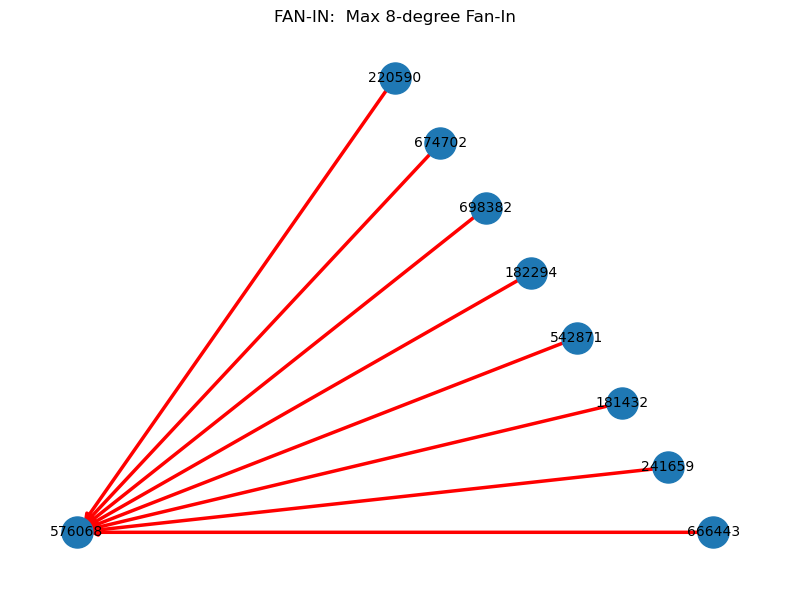

Pattern: GATHER-SCATTER:  Max 3-degree Fan-In
  #pattern rows: 9
  #nodes found: 10


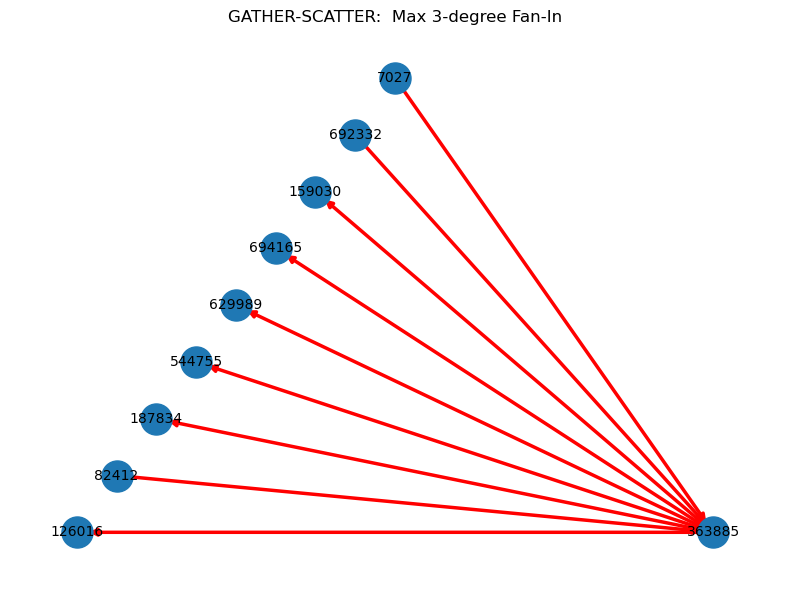

Pattern: RANDOM:  Max 10 hops
  #pattern rows: 10
  #nodes found: 11


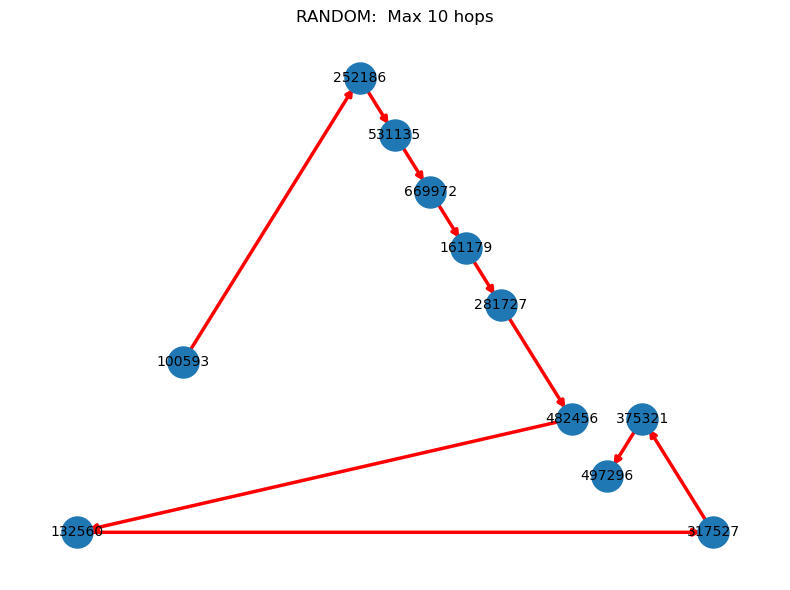

Pattern: SCATTER-GATHER
  #pattern rows: 12
  #nodes found: 8


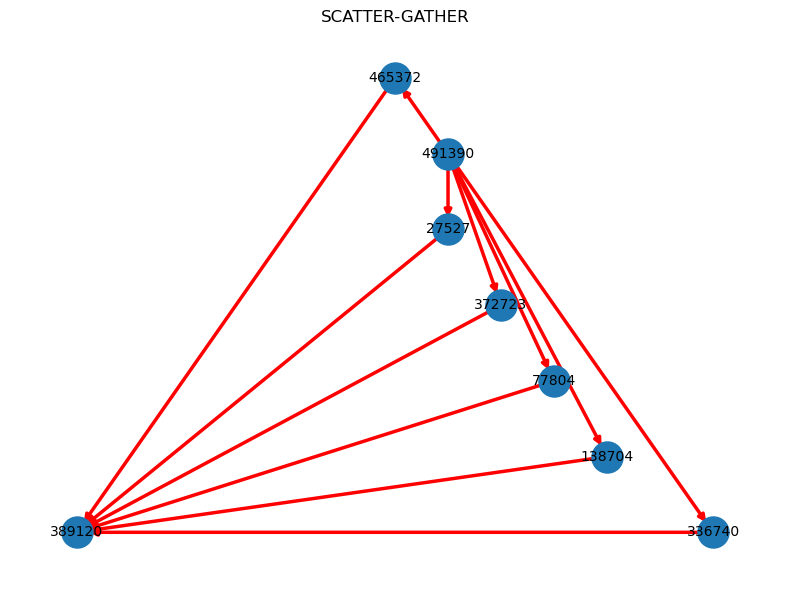

Pattern: GATHER-SCATTER:  Max 1-degree Fan-In
  #pattern rows: 2
  #nodes found: 2


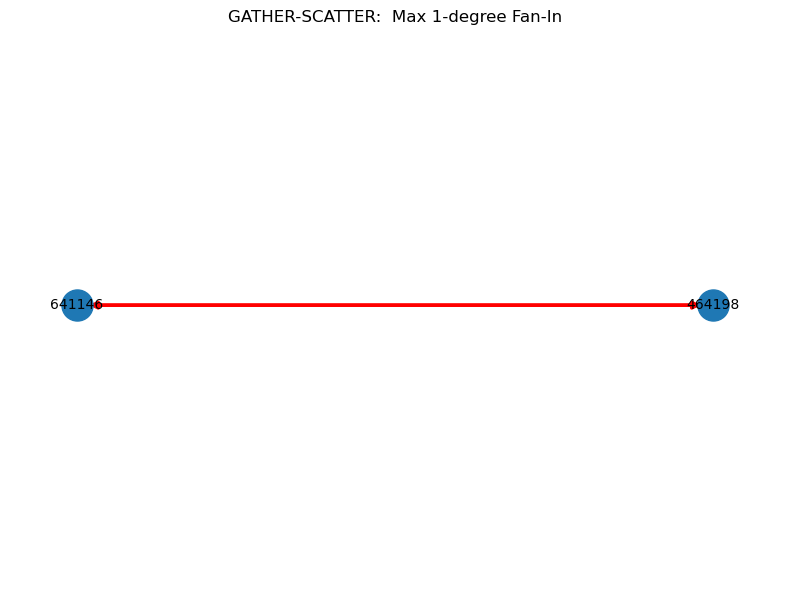

Pattern: RANDOM:  Max 4 hops
  #pattern rows: 4
  #nodes found: 5


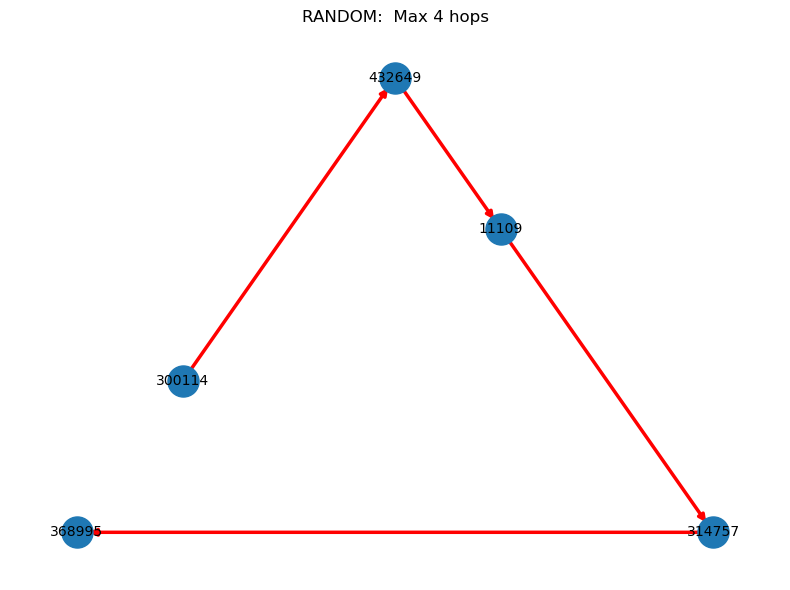

Pattern: FAN-OUT:  Max 3-degree Fan-Out
  #pattern rows: 3
  #nodes found: 4


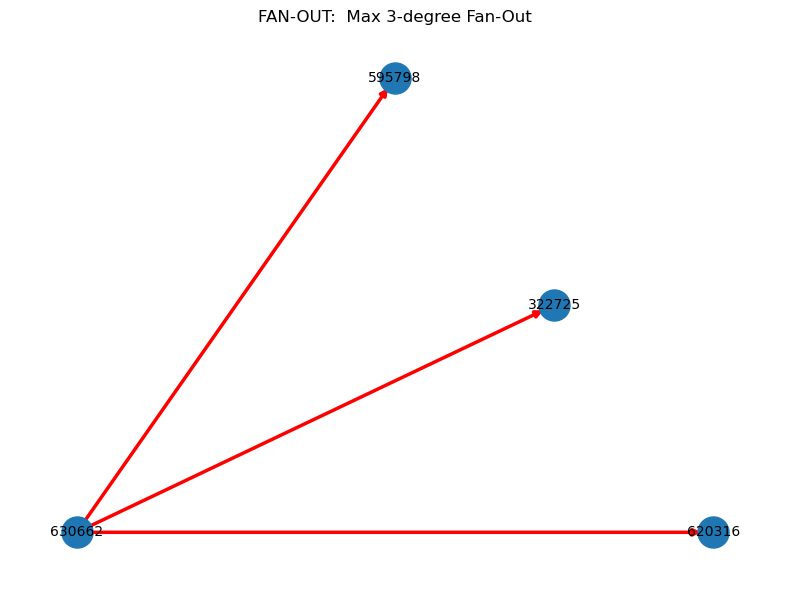

Pattern: FAN-IN:  Max 13-degree Fan-In
  #pattern rows: 13
  #nodes found: 14


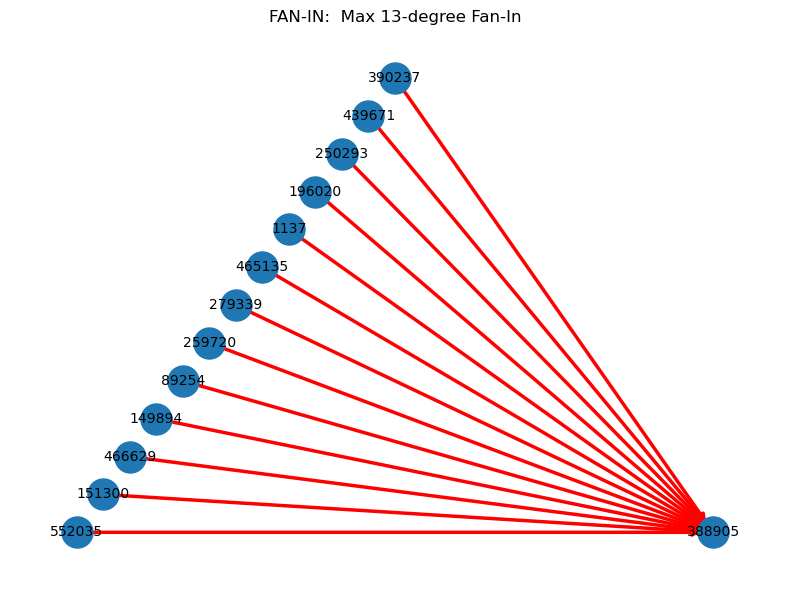

Pattern: STACK
  #pattern rows: 6
  #nodes found: 9


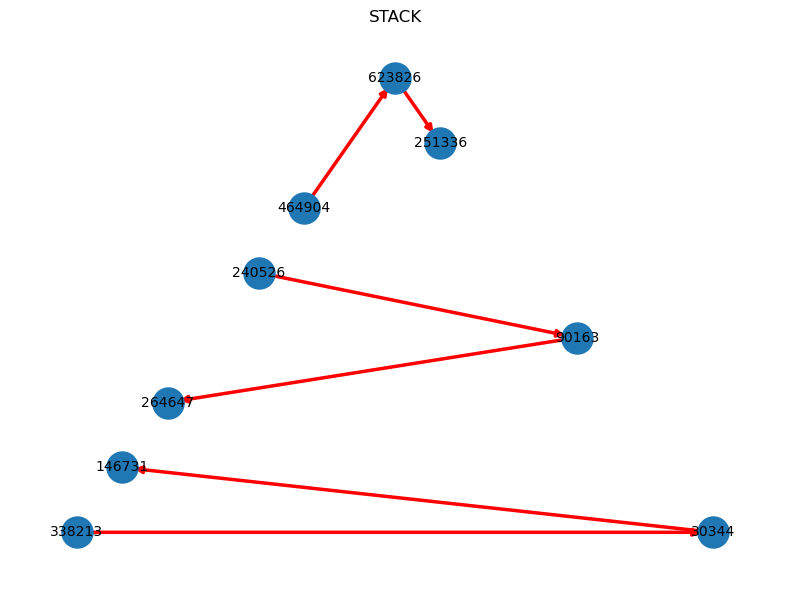

Pattern: FAN-IN:  Max 8-degree Fan-In
  #pattern rows: 8
  #nodes found: 9


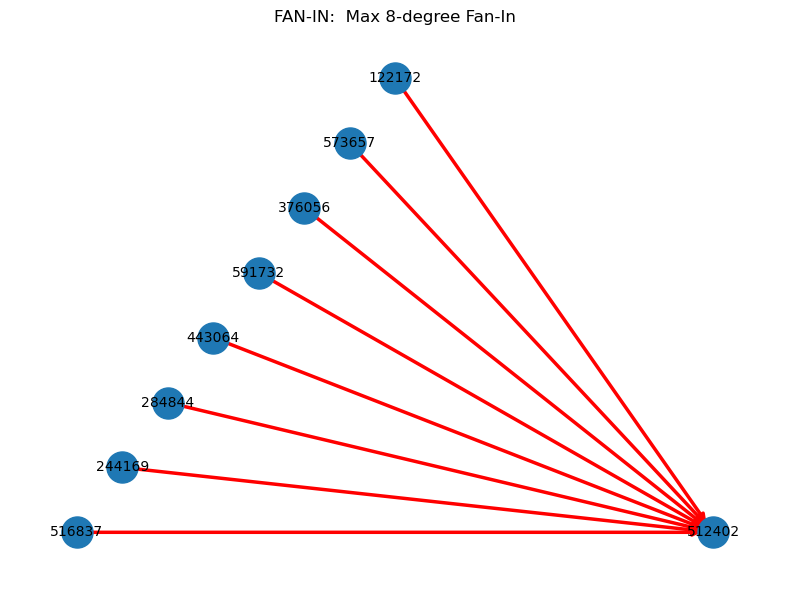

Pattern: FAN-IN:  Max 6-degree Fan-In
  #pattern rows: 6
  #nodes found: 7


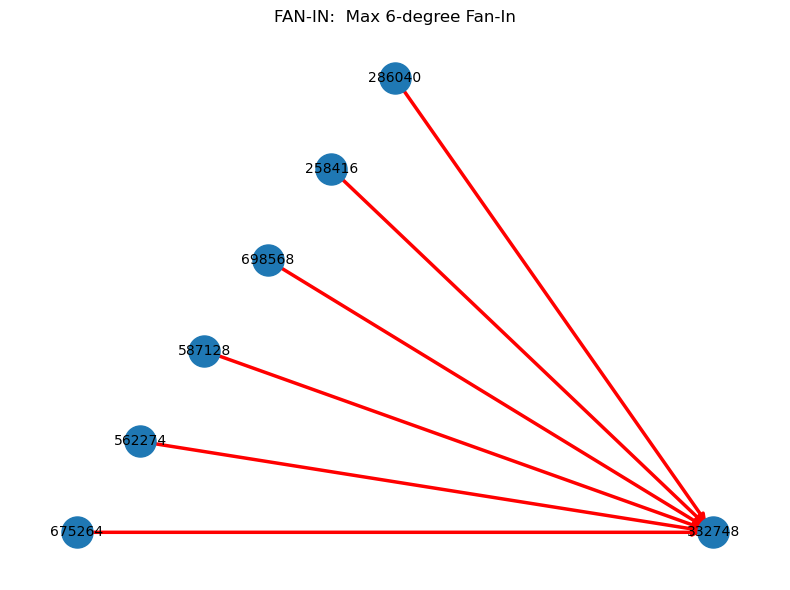

Pattern: FAN-OUT:  Max 15-degree Fan-Out
  #pattern rows: 15
  #nodes found: 16


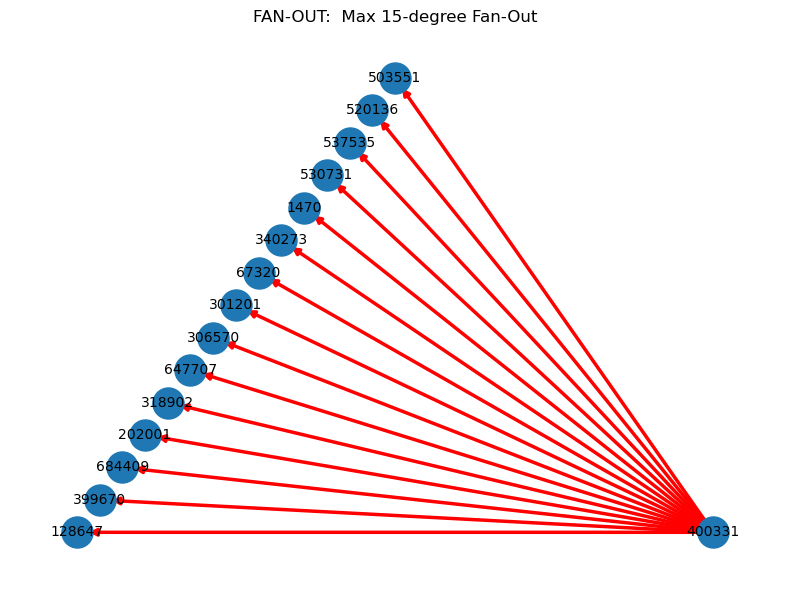

Pattern: FAN-OUT:  Max 15-degree Fan-Out
  #pattern rows: 15
  #nodes found: 16


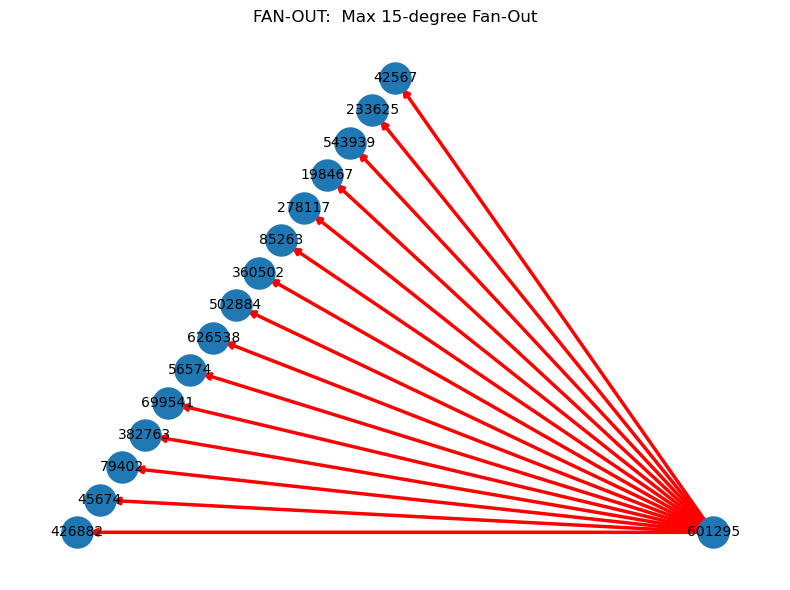

Pattern: RANDOM:  Max 11 hops
  #pattern rows: 11
  #nodes found: 12


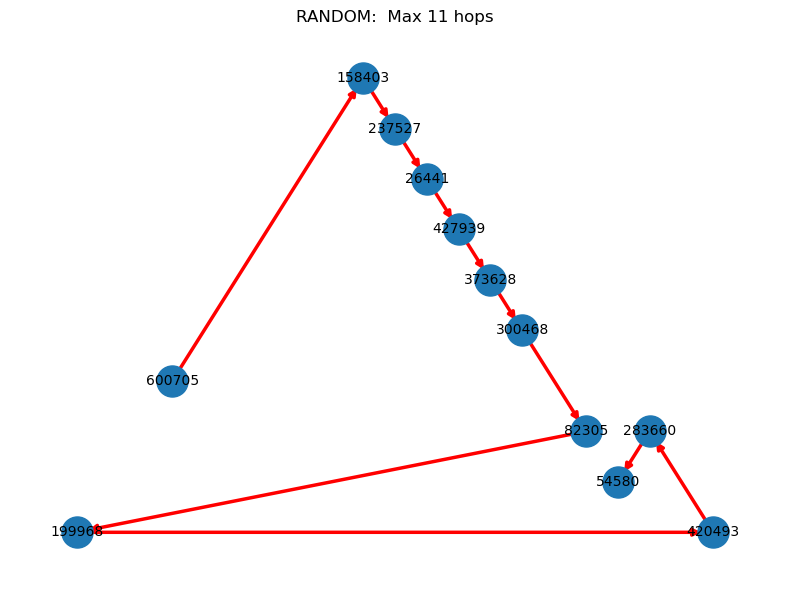

Pattern: FAN-IN:  Max 6-degree Fan-In
  #pattern rows: 6
  #nodes found: 7


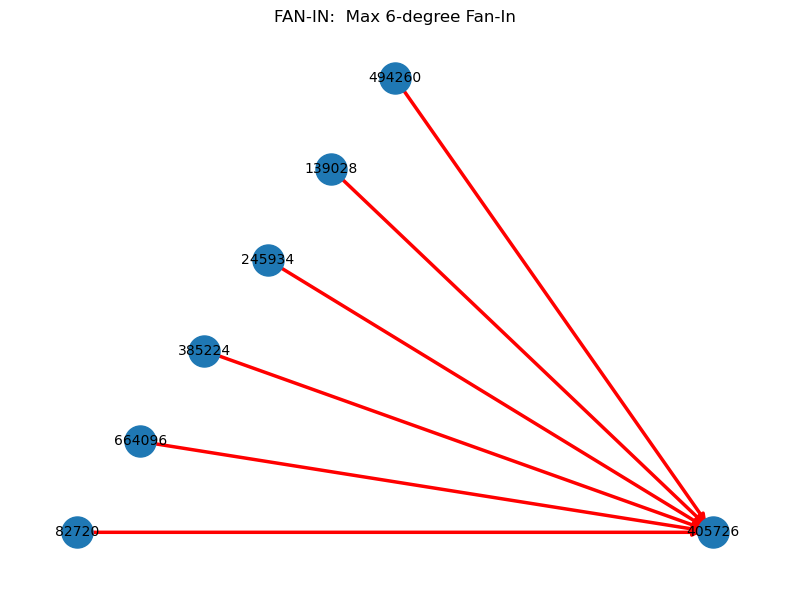

Pattern: RANDOM:  Max 2 hops
  #pattern rows: 2
  #nodes found: 3


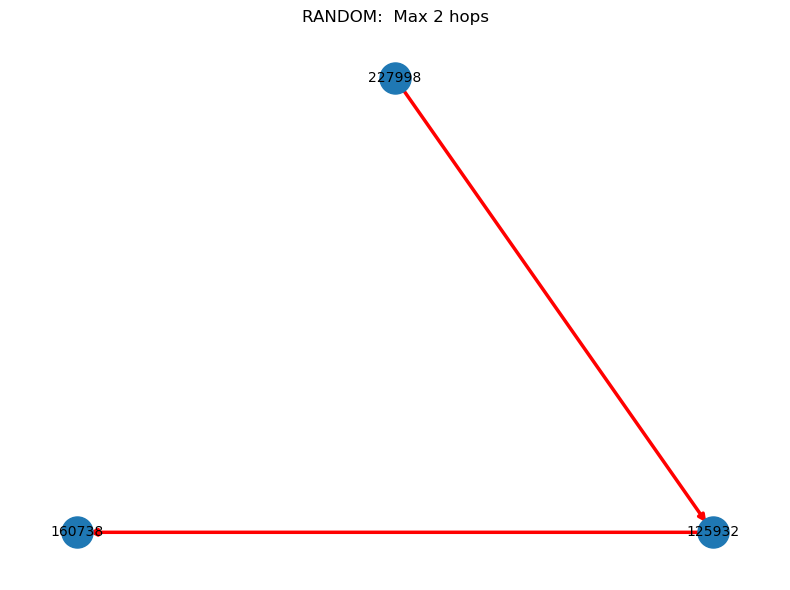

Pattern: STACK
  #pattern rows: 30
  #nodes found: 45


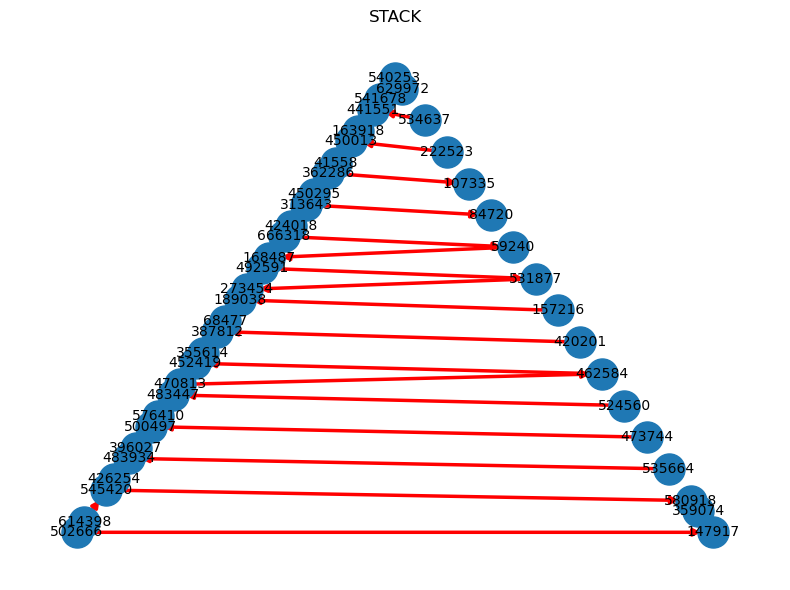

Pattern: STACK
  #pattern rows: 6
  #nodes found: 9


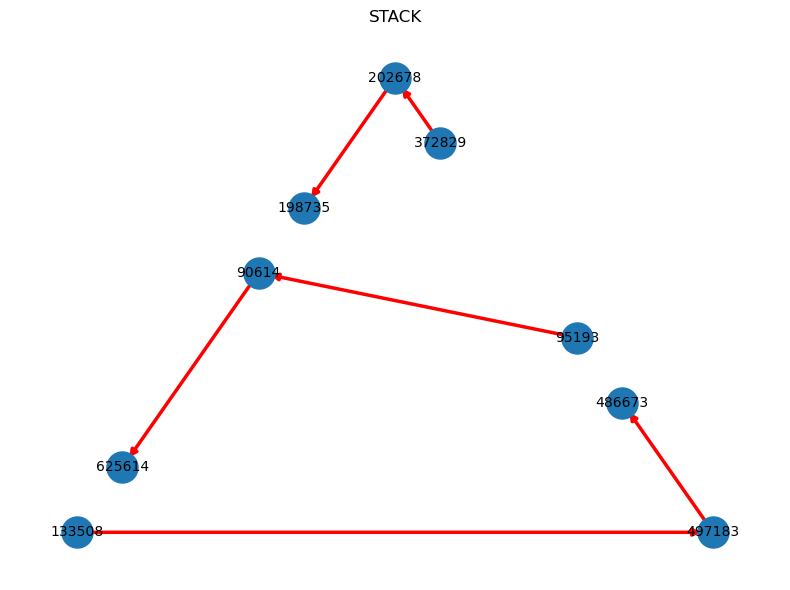

Pattern: RANDOM:  Max 1 hops
  #pattern rows: 1
  #nodes found: 2


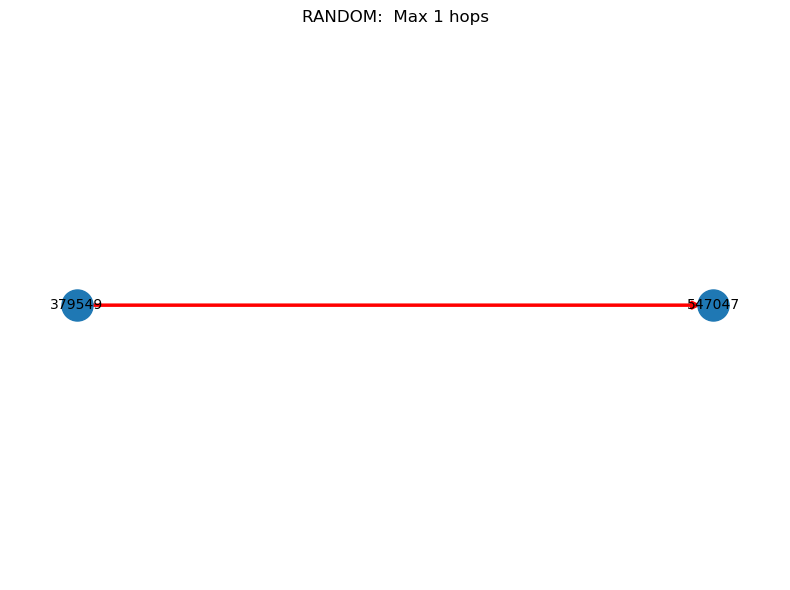

Pattern: GATHER-SCATTER:  Max 2-degree Fan-In
  #pattern rows: 18
  #nodes found: 19


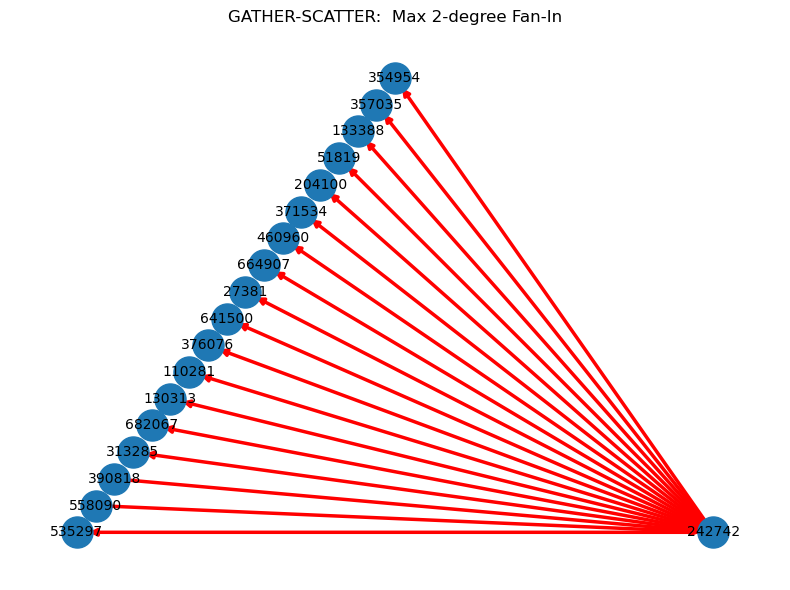

Pattern: SCATTER-GATHER
  #pattern rows: 30
  #nodes found: 17


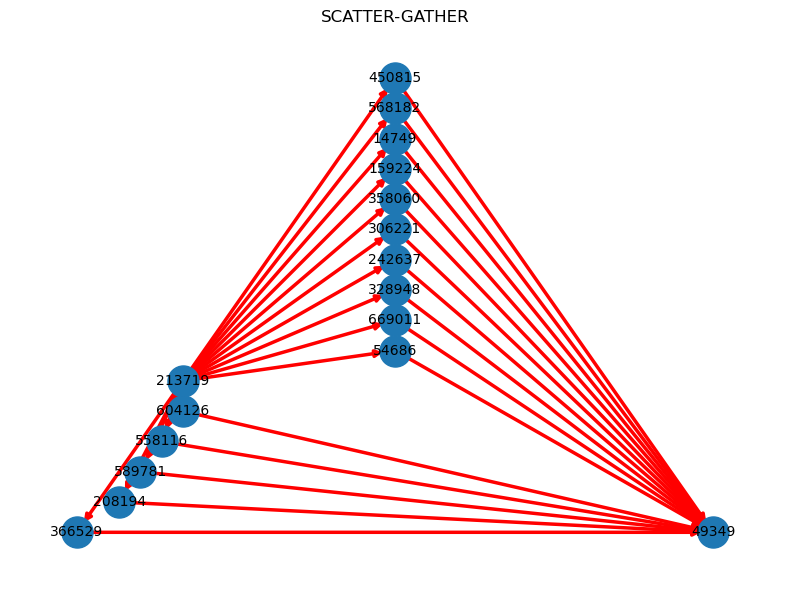

Pattern: STACK
  #pattern rows: 8
  #nodes found: 11


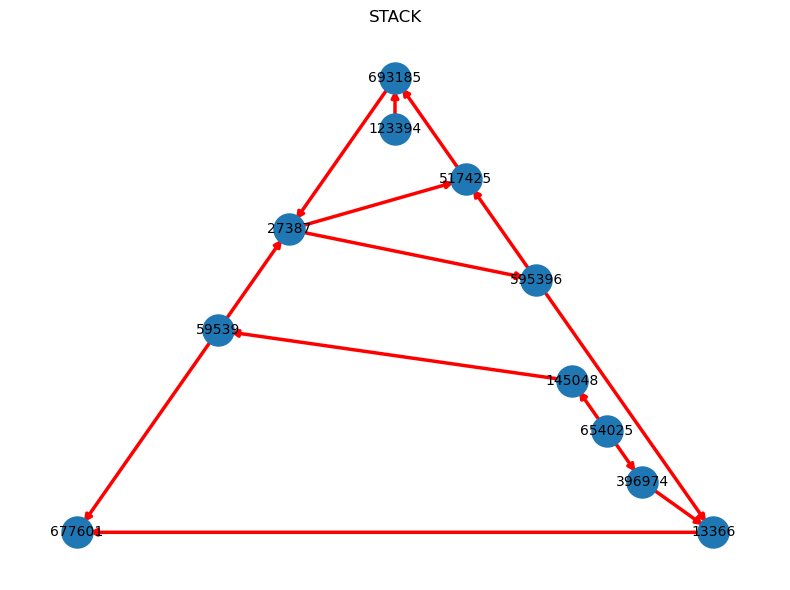

Pattern: STACK
  #pattern rows: 6
  #nodes found: 9


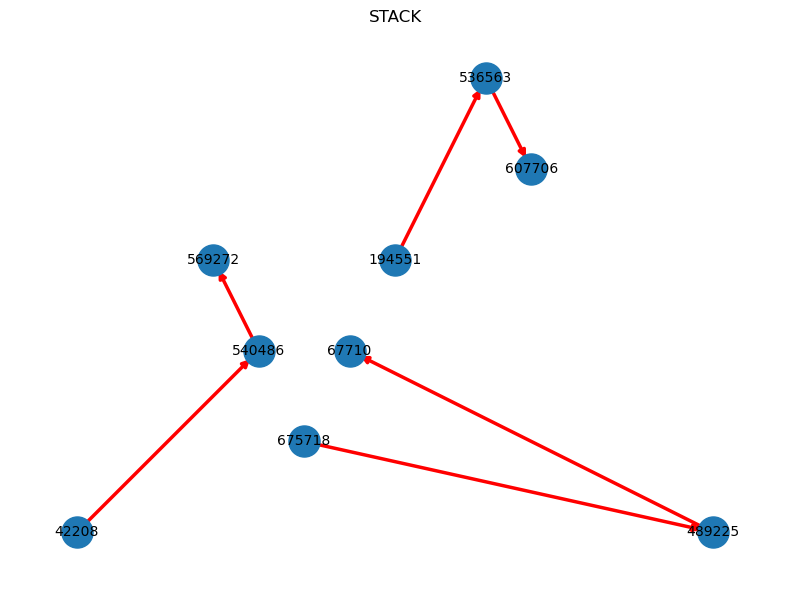

Pattern: STACK
  #pattern rows: 2
  #nodes found: 3


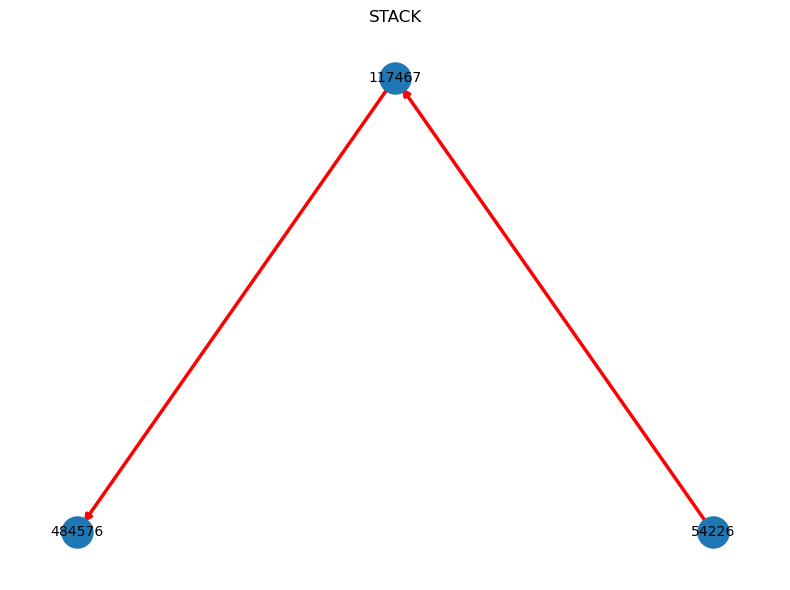

Pattern: STACK
  #pattern rows: 2
  #nodes found: 3


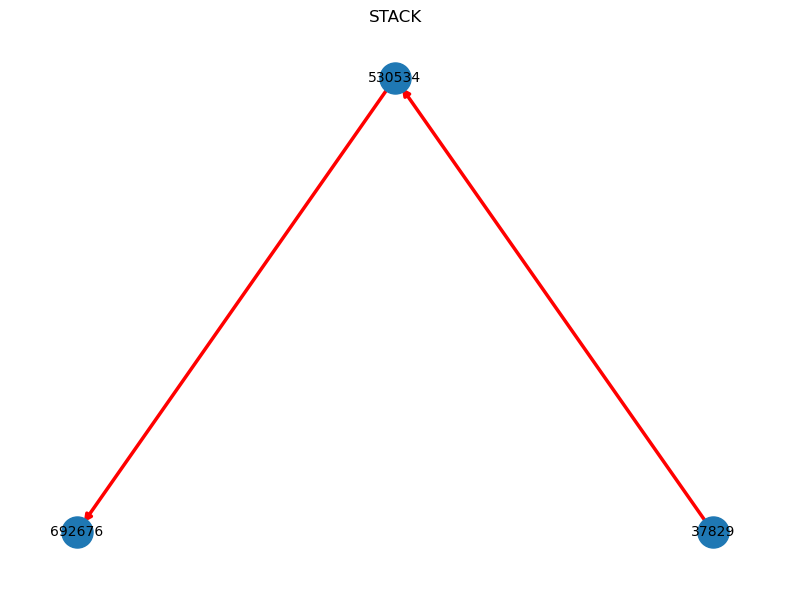

Pattern: BIPARTITE
  #pattern rows: 6
  #nodes found: 12


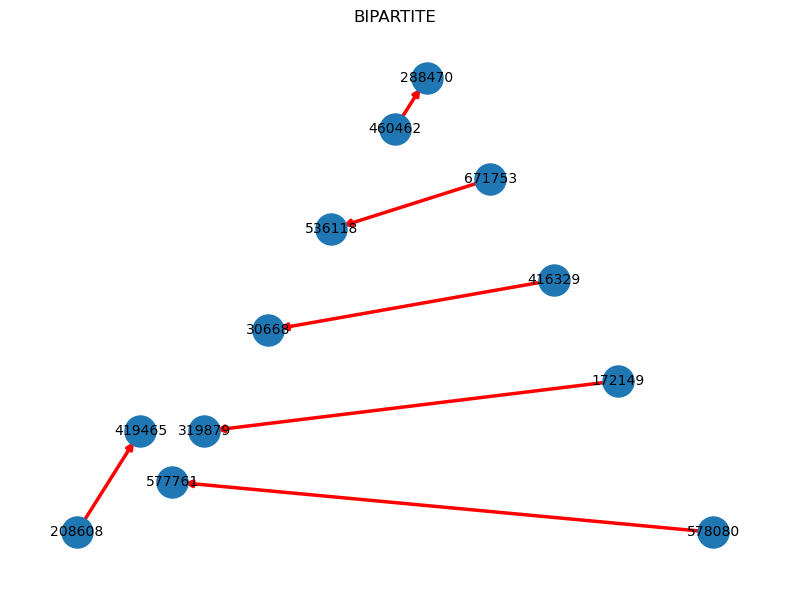

Pattern: FAN-OUT:  Max 3-degree Fan-Out
  #pattern rows: 3
  #nodes found: 4


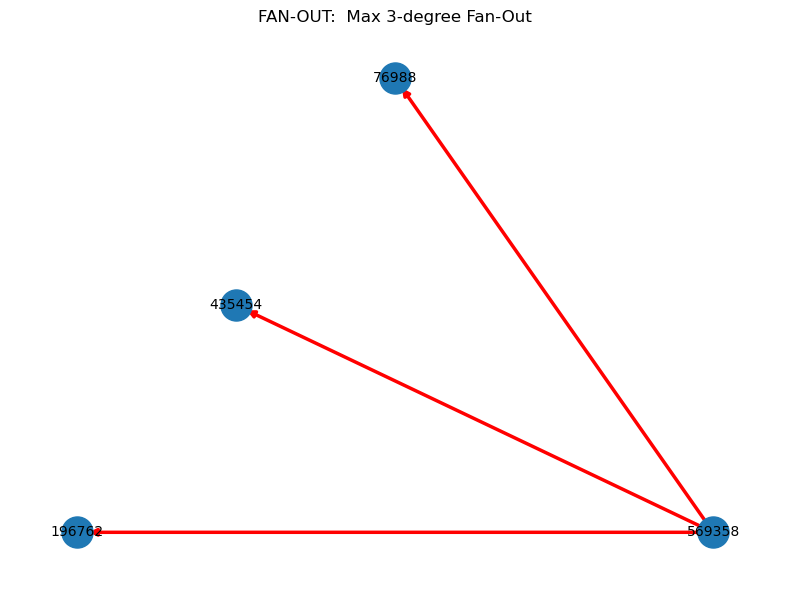

Pattern: FAN-OUT:  Max 7-degree Fan-Out
  #pattern rows: 7
  #nodes found: 8


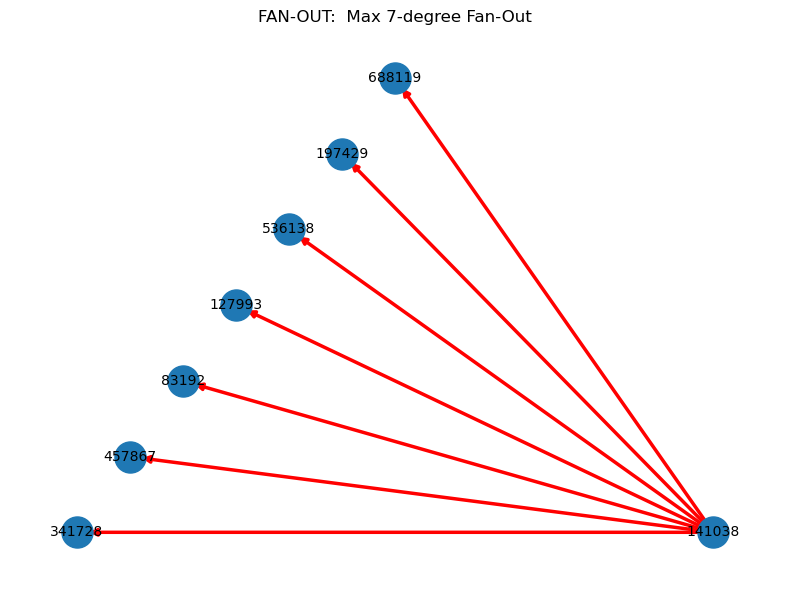

Pattern: SCATTER-GATHER
  #pattern rows: 2
  #nodes found: 2


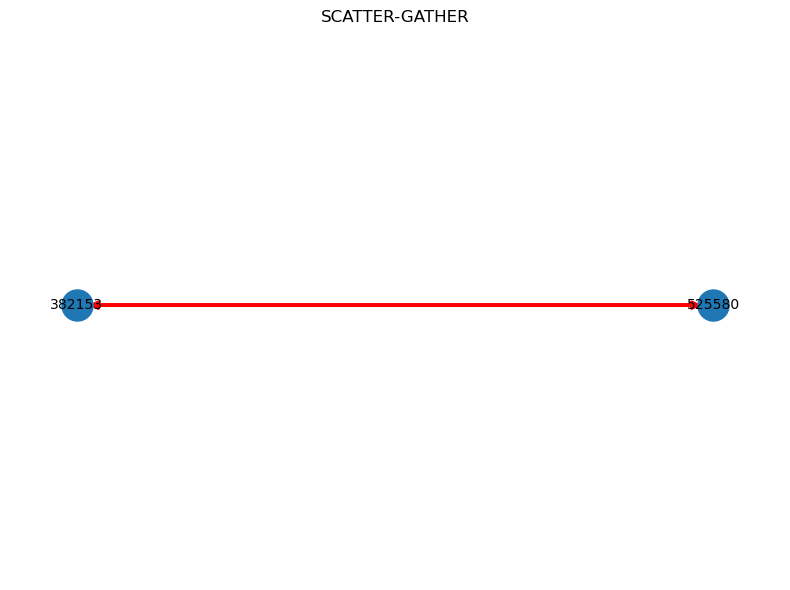

Pattern: GATHER-SCATTER:  Max 11-degree Fan-In
  #pattern rows: 23
  #nodes found: 24


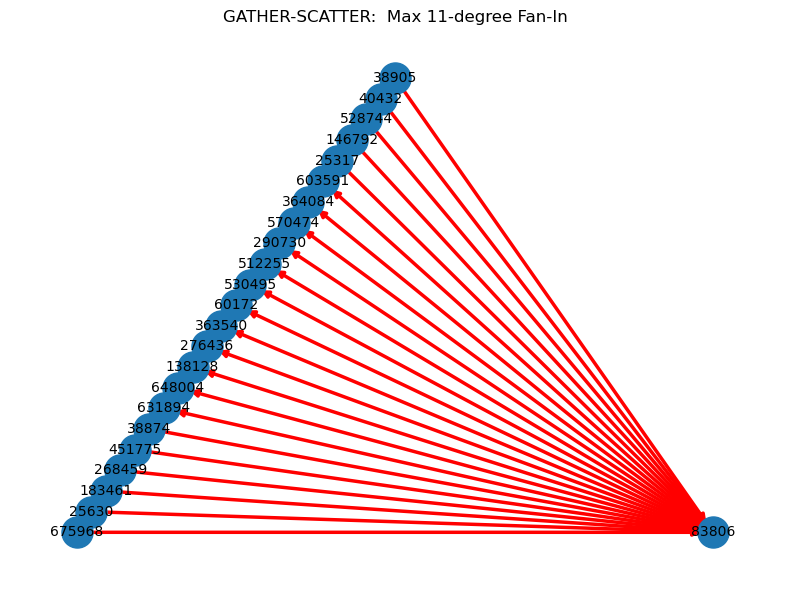

Pattern: GATHER-SCATTER:  Max 16-degree Fan-In
  #pattern rows: 24
  #nodes found: 25


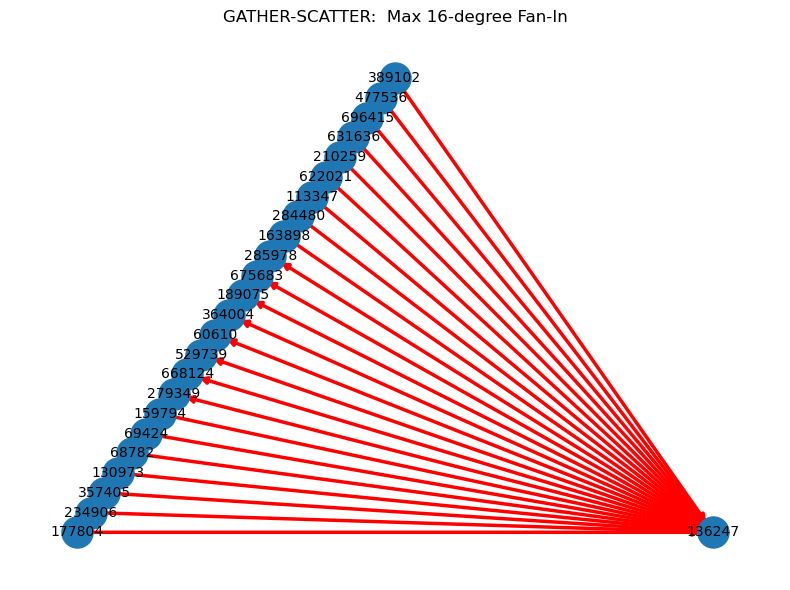

Pattern: CYCLE:  Max 11 hops
  #pattern rows: 11
  #nodes found: 11


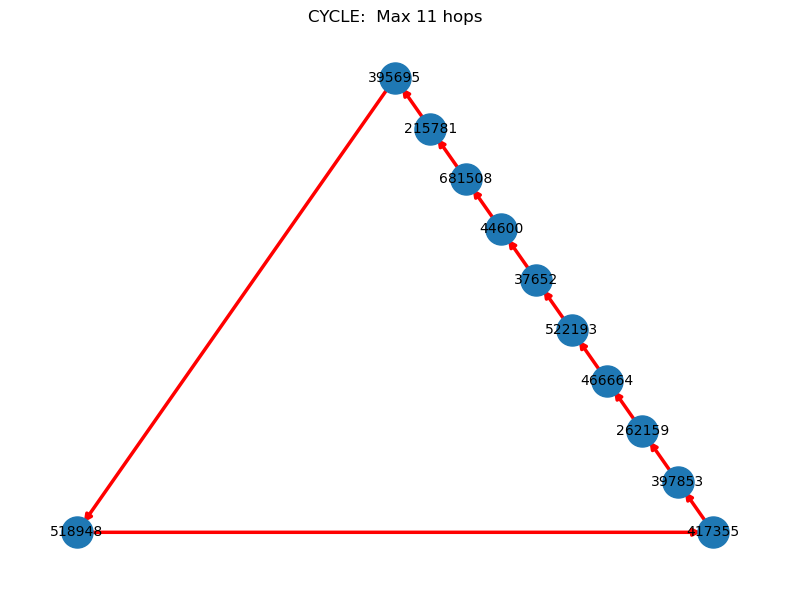

Pattern: STACK
  #pattern rows: 2
  #nodes found: 2


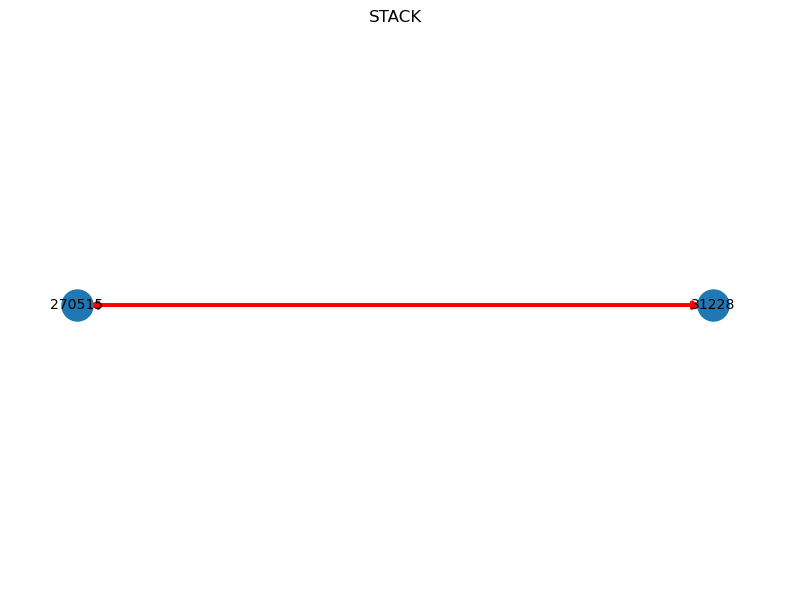

Pattern: BIPARTITE
  #pattern rows: 8
  #nodes found: 16


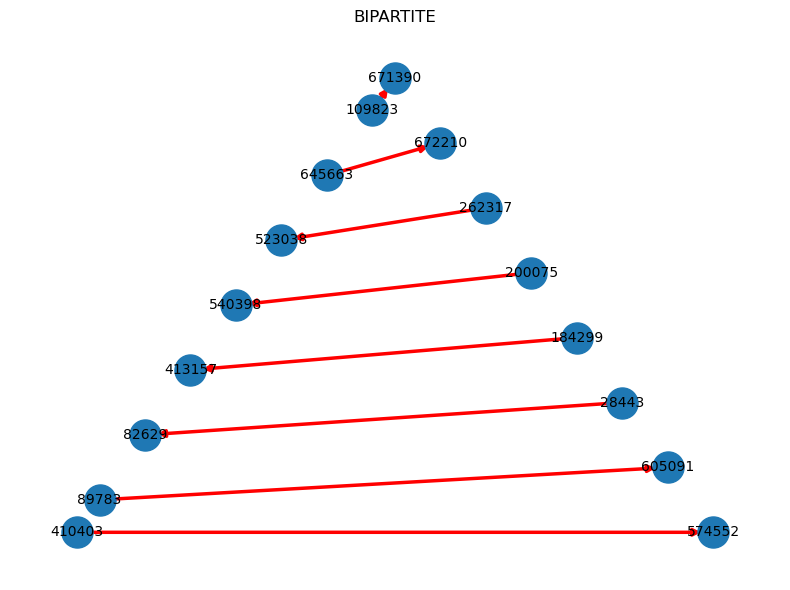

Pattern: FAN-OUT:  Max 3-degree Fan-Out
  #pattern rows: 3
  #nodes found: 4


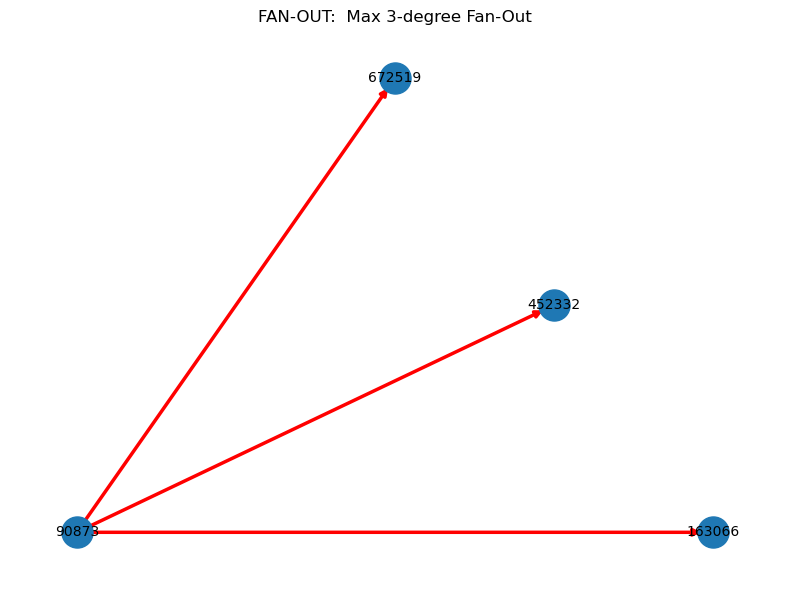

Pattern: FAN-OUT:  Max 5-degree Fan-Out
  #pattern rows: 5
  #nodes found: 6


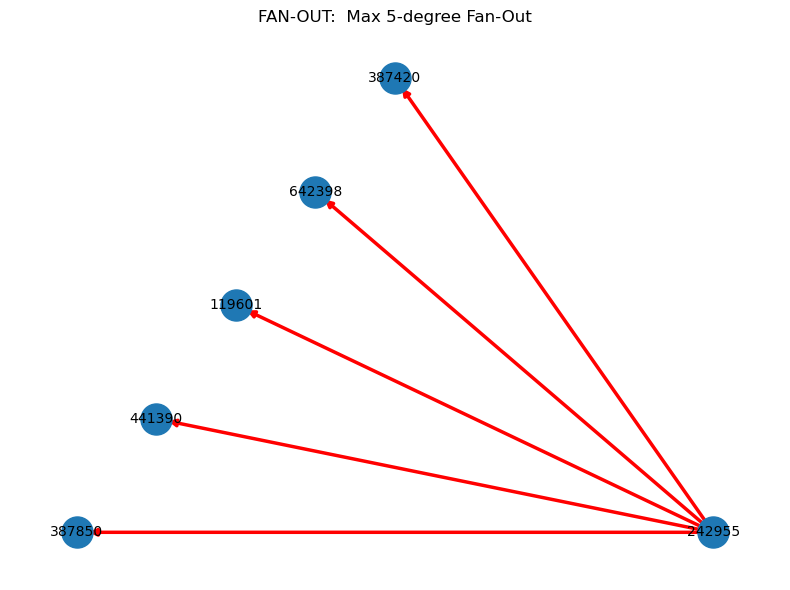

Pattern: FAN-OUT:  Max 2-degree Fan-Out
  #pattern rows: 2
  #nodes found: 3


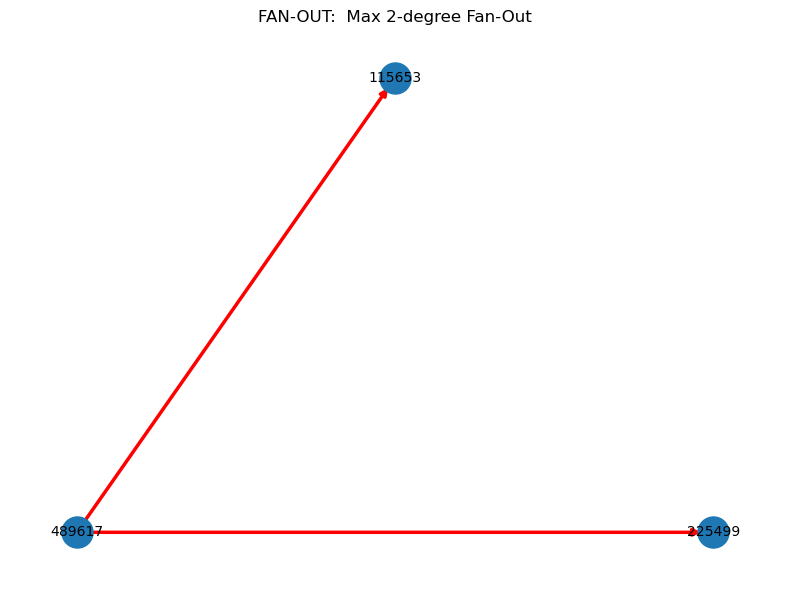

Pattern: CYCLE:  Max 3 hops
  #pattern rows: 3
  #nodes found: 3


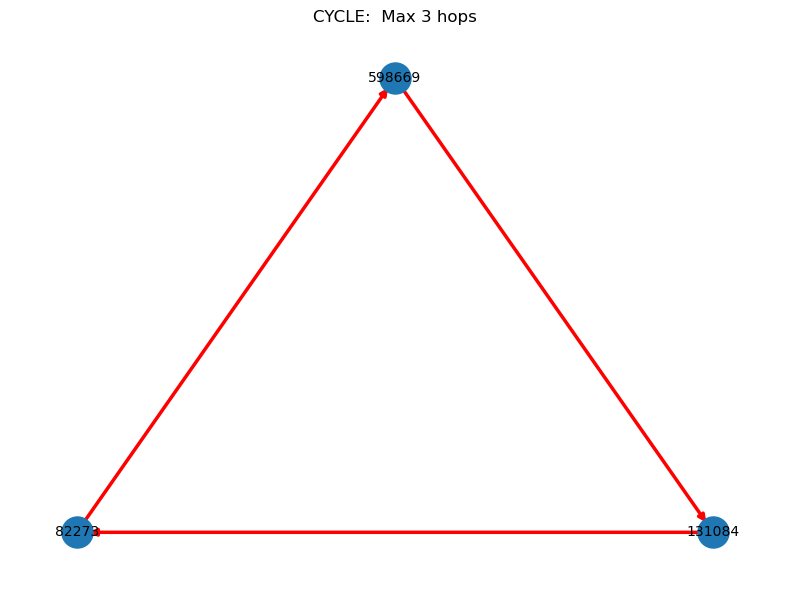

Pattern: STACK
  #pattern rows: 26
  #nodes found: 39


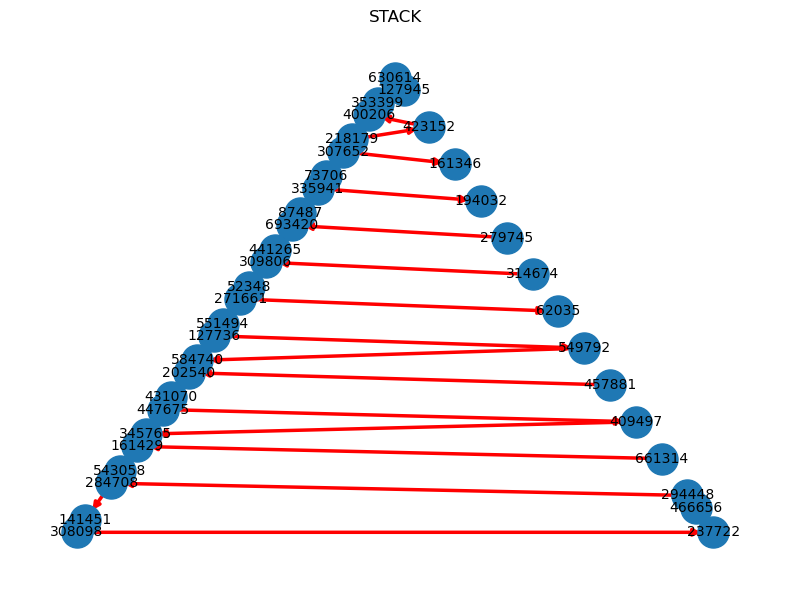

SchemaError: datatypes of join keys don't match - `from_account`: f64 on left does not match `from_account`: str on right

In [58]:
visualize_all_pats(
    './data/LI-Small_Patterns.txt',
    nodes.select(['account', 'node_id']),
    cmap,
    fmap,
    G
)